In [18]:
import pandas as pd
import re
import numpy as np
import geopandas as gpd

In [19]:
collision = pd.read_csv('data/pd_collisions_datasd_v1.csv')
# address with lat and long. coming from the sql database
address_with_geo = pd.read_csv('data/addressWithGeo.csv')

# combining parts of address to form into a valid input of google geocode api
collision = collision.dropna(subset=['address_road_primary'])
collision['address_sfx_primary'] = collision['address_sfx_primary'].fillna('')
collision['address_no_primary'] = collision['address_no_primary'].astype(str)
collision['address'] = collision[['address_no_primary', 
                                  'address_pd_primary', 
                                  'address_road_primary', 
                                  'address_sfx_primary']].agg(' '.join, axis=1)\
                                                         .apply(lambda x: re.sub(' +', ' ', x))
# converting date_time into datetime object
collision['date_time'] = pd.to_datetime(collision['date_time'])

In [17]:
print(pd.read_csv('data/pd_beat_codes_list_datasd.csv').head().to_markdown())

|    |   beat | neighborhood         |
|---:|-------:|:---------------------|
|  0 |    111 | Clairemont Mesa East |
|  1 |    112 | Clairemont Mesa West |
|  2 |    113 | Bay Ho               |
|  3 |    114 | North Clairemont     |
|  4 |    115 | University City      |


<AxesSubplot: >

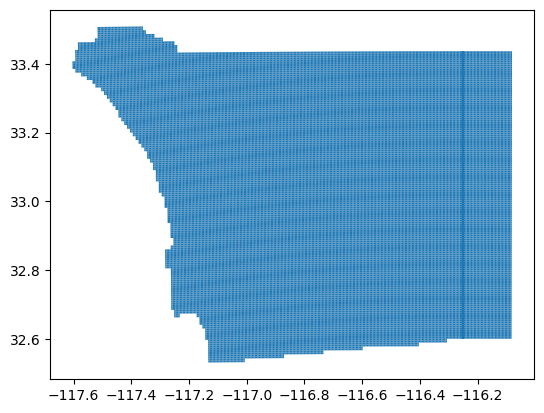

In [27]:
# grid shp file of san diego, downloaded from https://www.sangis.org/
sd_grid = gpd.read_file('data/GRID_RPSG_GRIDSUB/GRID_RPSG_GRIDSUB.shp')
sd_grid = sd_grid[['geometry', 'MAPPAGE', 'Shape_STAr', 'Shape_STLe']]
# convert into long, lat to match what I have
sd_grid = sd_grid.to_crs(epsg=4326)

sd_grid.plot()

<AxesSubplot: >

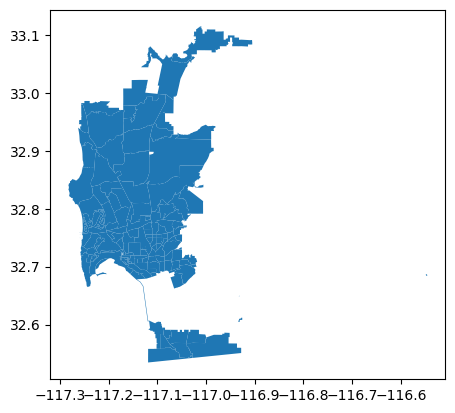

In [30]:
# shp file of san diego county that police department covers
police_beat = gpd.read_file('data/pd_beats_datasd/pd_beats_datasd.shp')
police_beat = police_beat.to_crs(epsg=4326)

police_beat.plot()

## Use San Diego County shp file to extract grids that are inside San Diego County

<AxesSubplot: >

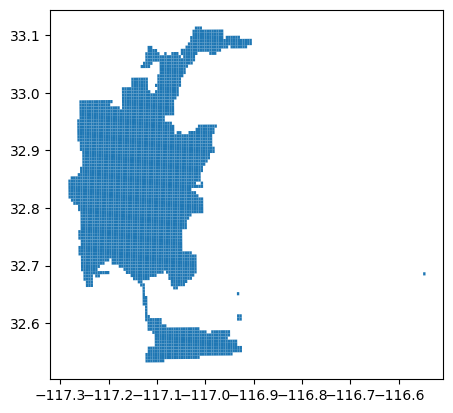

In [34]:
# use intersects() from geopandas to achieve this
extract_necessary_grids = [np.any(police_beat['geometry'].intersects(g)) for g in sd_grid['geometry']]
sd_grid_trim = sd_grid[extract_necessary_grids]
sd_grid_trim.plot()

## Grouping different charge_desc into higher categories

In [45]:
# extract causes that occur more than or equal to 3 times since 2016
cd = collision['charge_desc'].value_counts()
cd = cd[cd >= 3].index
#pd.DataFrame(cd, columns=['original_cause']).to_csv('data/charge_desc.csv')

# reading the file after manually assigning each unique causes
cd_abbre = pd.read_csv('data/charge_desc.csv', index_col='Unnamed: 0')

## Assigning each collision into appropriate grid

In [46]:
# merging two df so that long and lat are included
collision_geo = collision.merge(address_with_geo, 
                                how='left', 
                                left_on='address', 
                                right_on='address')
collision_geo.to_csv('data/collision_geo.csv')

# merging two df so that preprocessed charge_desc is included
clean_geo_charge = collision_geo[collision_geo['charge_desc'].isin(cd)].merge(cd_abbre, 
                                                                              left_on='charge_desc', 
                                                                              right_on='original_cause')

# add geometry column so that I can connect location of accident to each grid
collision_gdf = gpd.GeoDataFrame(
    clean_geo_charge, crs="EPSG:4326",
    geometry=gpd.points_from_xy(
        collision_geo["long"], collision_geo["lat"]
    ),
)

# removing 2015 since there are less than 50 points for the entire year, which is a mistake
collision_gdf = collision_gdf[collision_gdf['date_time'].dt.year > 2015]
collision_gdf.loc[:,'y_m'] = collision_gdf['date_time'].dt.to_period('M')

In [61]:
# using gpd.sjoin to connect collision location to each grid
joined = gpd.sjoin(
    collision_gdf, 
    sd_grid_trim, 
    how='left',
    predicate="within",
)
joined.to_csv('data/collision_by_grid.csv')

## Calculating cumulative sum of each grid with month interval

In [65]:
cumsum_collision = joined.groupby(['y_m', 'MAPPAGE'])['report_id'].count().reset_index()
cumsum_collision['cum_sum'] = cumsum_collision.groupby(['MAPPAGE'])['report_id'].cumsum()
cumsum_collision['y_m'] = cumsum_collision['y_m'].astype(str)
cumsum_collision_pt = cumsum_collision.pivot_table(index='y_m', columns='MAPPAGE',values='cum_sum')
# to make sure each grid starts with at least 0 collision
cumsum_collision_pt.loc['2016-00'] = 0
cumsum_collision_pt = cumsum_collision_pt.sort_index()

# taking care of grids that have 0 collision until today
zero_collision_grids = [m for m in sd_grid_trim['MAPPAGE'].values if m not in cumsum_collision_pt.columns]
zero_collision_grids = {m:[0] for m in zero_collision_grids}
zero_collision_df = pd.DataFrame(index = [cumsum_collision_pt.index[0]], data=zero_collision_grids)
# dropping grid that is covering ocean
zero_collision_df = zero_collision_df.drop(columns=['1135-D1', '0835-D2', '0735-D1', '0736-A1', '0836-A2', '1455-C1'])

# concating the two dataframe
# bringing count from previous month when there is no new collision in a grid for current month
cumsum_collision_final = pd.concat([cumsum_collision_pt, zero_collision_df], axis=1).fillna(method='ffill', axis=0)

# turning from wide to long format
cumsum_collision_final.iloc[1:,:].unstack().reset_index().rename(columns={0: 'cumsum'}).to_csv('data/cumsum_total_collision.csv')